In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import datetime as dt
import os
import matplotlib.pyplot as plt
import phonecalls as pc
import scipy.stats as stats
import scipy.interpolate as interpol
import scipy as spy
import statsmodels.api as sm
import pymannkendall as mk
import time
import copy
import math
import pickle
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


plt.rcParams['figure.figsize'] = (20, 10)
markers = ['o', 'v', 's', 'P', '*', 'X', 'd', 'x', 'D', '2', '+']
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

data = {}
for i in range(5):
    with open(f'data/{["UKc", "UKt", "USc", "USt", "IT"][i]}.pkl', 'rb') as f:
        tmp = pickle.load(f)
        tmp = tmp.reset_index(drop=True)
        data[['ukc', 'ukt', 'usc', 'ust', 'it'][i]] = tmp
        f.close()

In [2]:
t0 = dt.datetime.now()
weekdays = {}
for c in data.keys():
    df = data[c].copy(deep=True)
    df['weekday'] = df['date'].map(lambda i: i.day_name())
    weekdays[c] = {}
    for t in df['t'].unique():
        df1 = df.loc[df['t'] == t]
        weekdays[c][t] = df1.iloc[0]['weekday']

In [3]:
def get_teeth(calls, tau=False):
    lf = calls.groupby('pair')[['a']].max()
    if tau:
        to = calls.groupby('pair')[['tau']].min().rename({'tau': 't', 'a': 'ell'}, axis='columns')
    else:
        to = calls.groupby('pair')[['t']].min()
    df = to.merge(lf, left_index=True, right_index=True, how='left').rename({'t': 'to', 'a': 'ell'}, axis='columns')
    df = df.sort_values(by=['to', 'ell']).reset_index()
    df['x'] = df['to'] + df.index
    result = pd.DataFrame()
    for t in df['to'].unique():
        tdf = df.loc[df['to'] == t].reset_index(drop=True)
        tdf['ac'] = tdf.index
        result = result.append(tdf)
    result = result.reset_index(drop=True)
    at = result.groupby('to')['pair'].count()
    result['xrel'] = result.index.map(lambda i: (result.at[i, 'ac'] / at[result.at[i, 'to']]) + result.at[i, 'to'])
    return result

In [4]:
teeth = {}
for c in data.keys():
    df = get_teeth(data[c])
    teeth[c] = df

# UK

In [5]:
daynames = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekly = {}
for nw in [7 * weeks for weeks in [1,4,8,12,16,20,24,28]]:
    subpairs = teeth['ukc'].loc[(teeth['ukc']['to'] >= 200) & (teeth['ukc']['to'] < 200 + nw)]
    subdata = data['ukc'][data['ukc']['pair'].isin(subpairs['pair'])].copy()
    subsubdata = pd.DataFrame()
    for t in subpairs['to'].unique():
        alters = list(subpairs.loc[subpairs['to'] == t]['pair'])
        tmp = subdata[subdata['pair'].isin(alters)]
        tmp = tmp.loc[tmp['t'] <= t + 200]
        subsubdata = subsubdata.append(tmp)
    tt = get_teeth(subsubdata)
    tt['weekday'] = tt['to'].map(lambda x: weekdays['ukc'][x])
    weekly[nw // 7] = pd.DataFrame()
    for i in range(7):
        tmp = tt.loc[tt['weekday'] == daynames[i]]
        tmp = tmp.sort_values(by=['ell']).reset_index(drop=True)
        tmp['xrel'] = tmp.index.map(lambda x: (x / len(tmp)) + i*2)
        weekly[nw // 7] = weekly[nw // 7].append(tmp).reset_index(drop=True)

In [6]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i]/2,y[i])

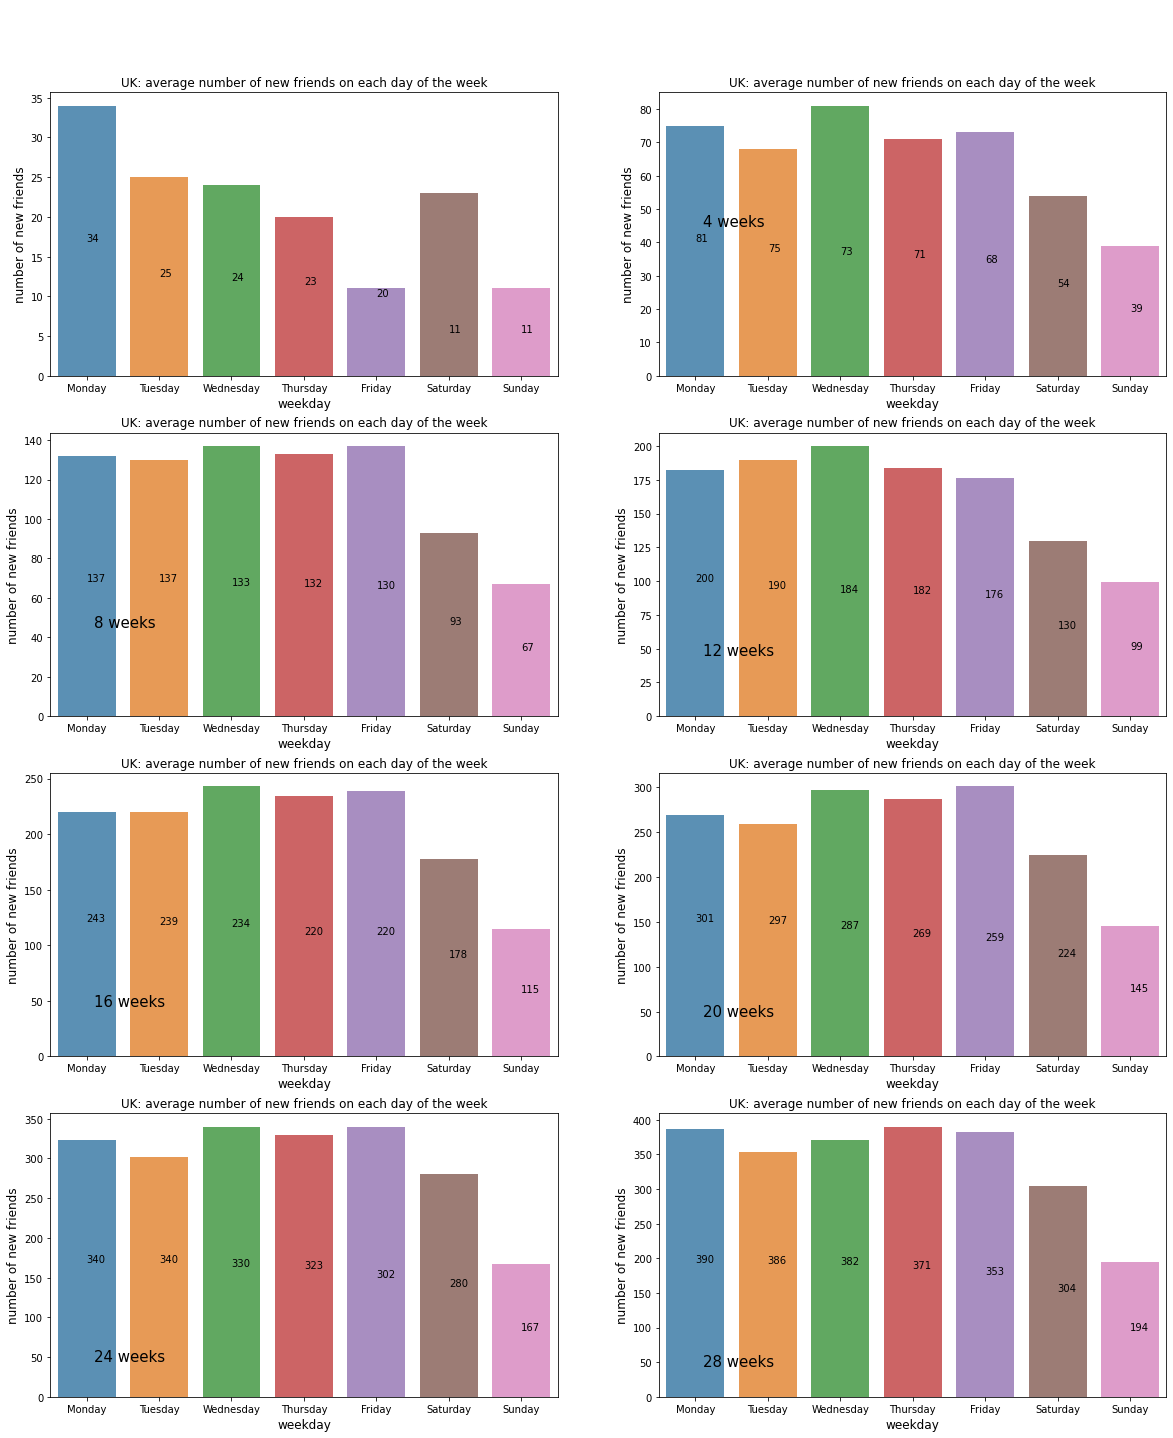

In [80]:
nc = 2
nr = 4
plt.figure(figsize=(10*nc, 6*nr))
p = 1  

for nw in weekly.keys():
    plt.subplot(nr, nc, p)
    value_counts  = weekly[nw]['weekday'].value_counts()
    sns.barplot(value_counts.index, value_counts.values, alpha=0.8,order = daynames)
    addlabels(value_counts.index, value_counts.values)
    plt.title('UK: average number of new friends on each day of the week')
    plt.ylabel('number of new friends', fontsize=12)
    plt.xlabel('weekday', fontsize=12)
    plt.annotate(f'{nw} weeks', (0.1, 45), fontsize=15)
    #plt.tight_layout()
    p += 1
# plt.savefig("/home/vsvh/Desktop/UKc.pdf", dpi=300)

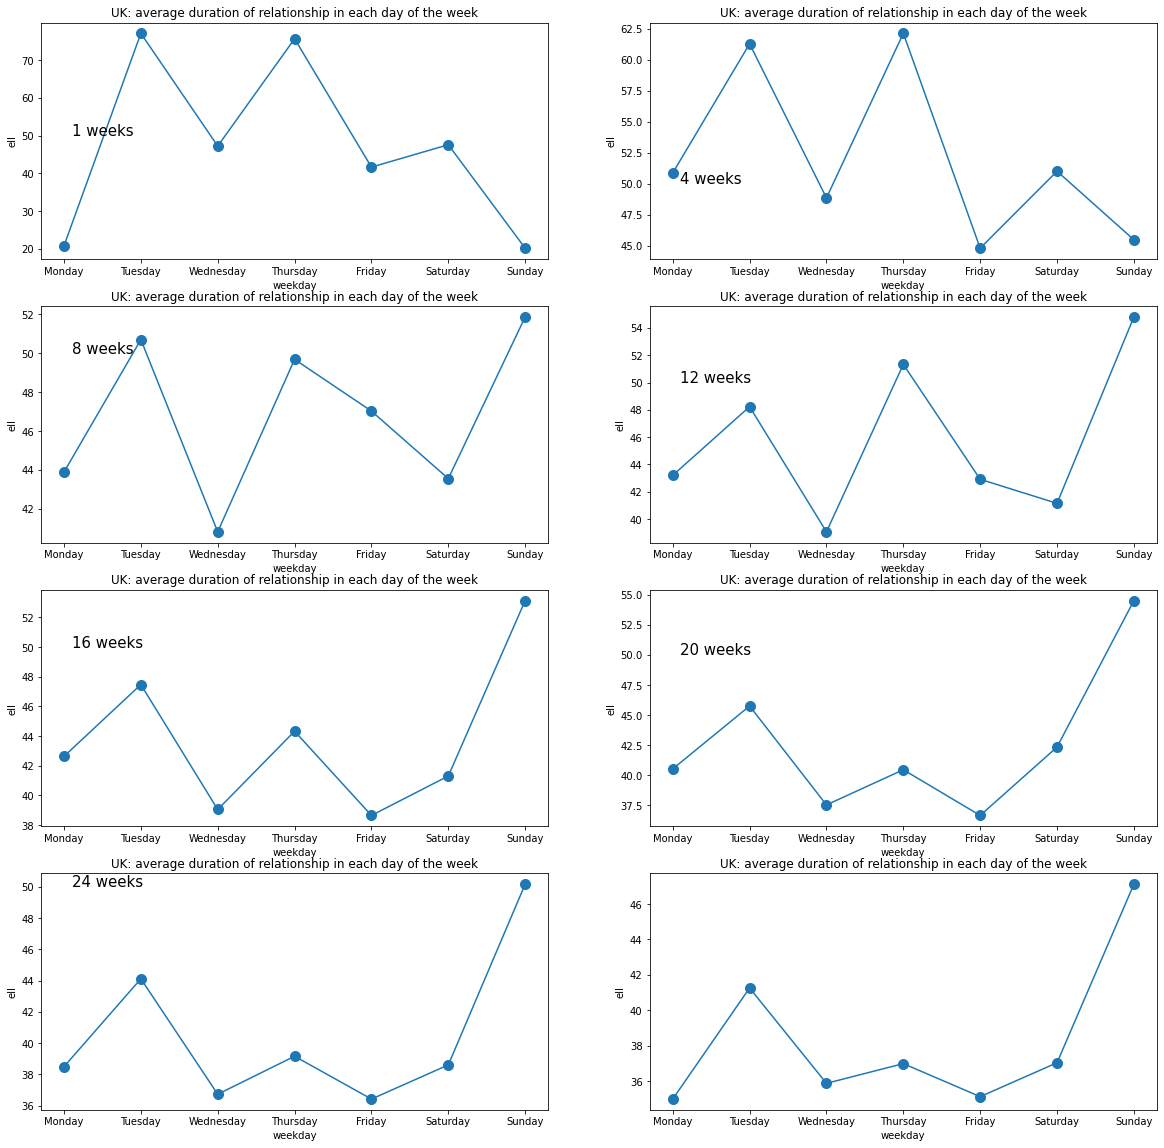

In [81]:
nc = 2
nr = 4
plt.figure(figsize=(10*nc, 5*nr))
p = 1
for nw in weekly.keys():
    plt.subplot(nr, nc, p)
    size = weekly[nw].groupby('weekday',sort = False)
    means = size.mean()
    #  average duration of friendships in each day of the week
    plt.plot(means['ell'], linestyle='-', marker='o', markersize=10)
    plt.title('UK: average duration of relationship in each day of the week')
    plt.xlabel(means.index.name)
    plt.ylabel('ell')
    plt.annotate(f'{nw} weeks', (0.1, 50), fontsize=15)
    #plt.tight_layout()
    p += 1
# plt.savefig("/home/vsvh/Desktop/UKc.pdf", dpi=300)

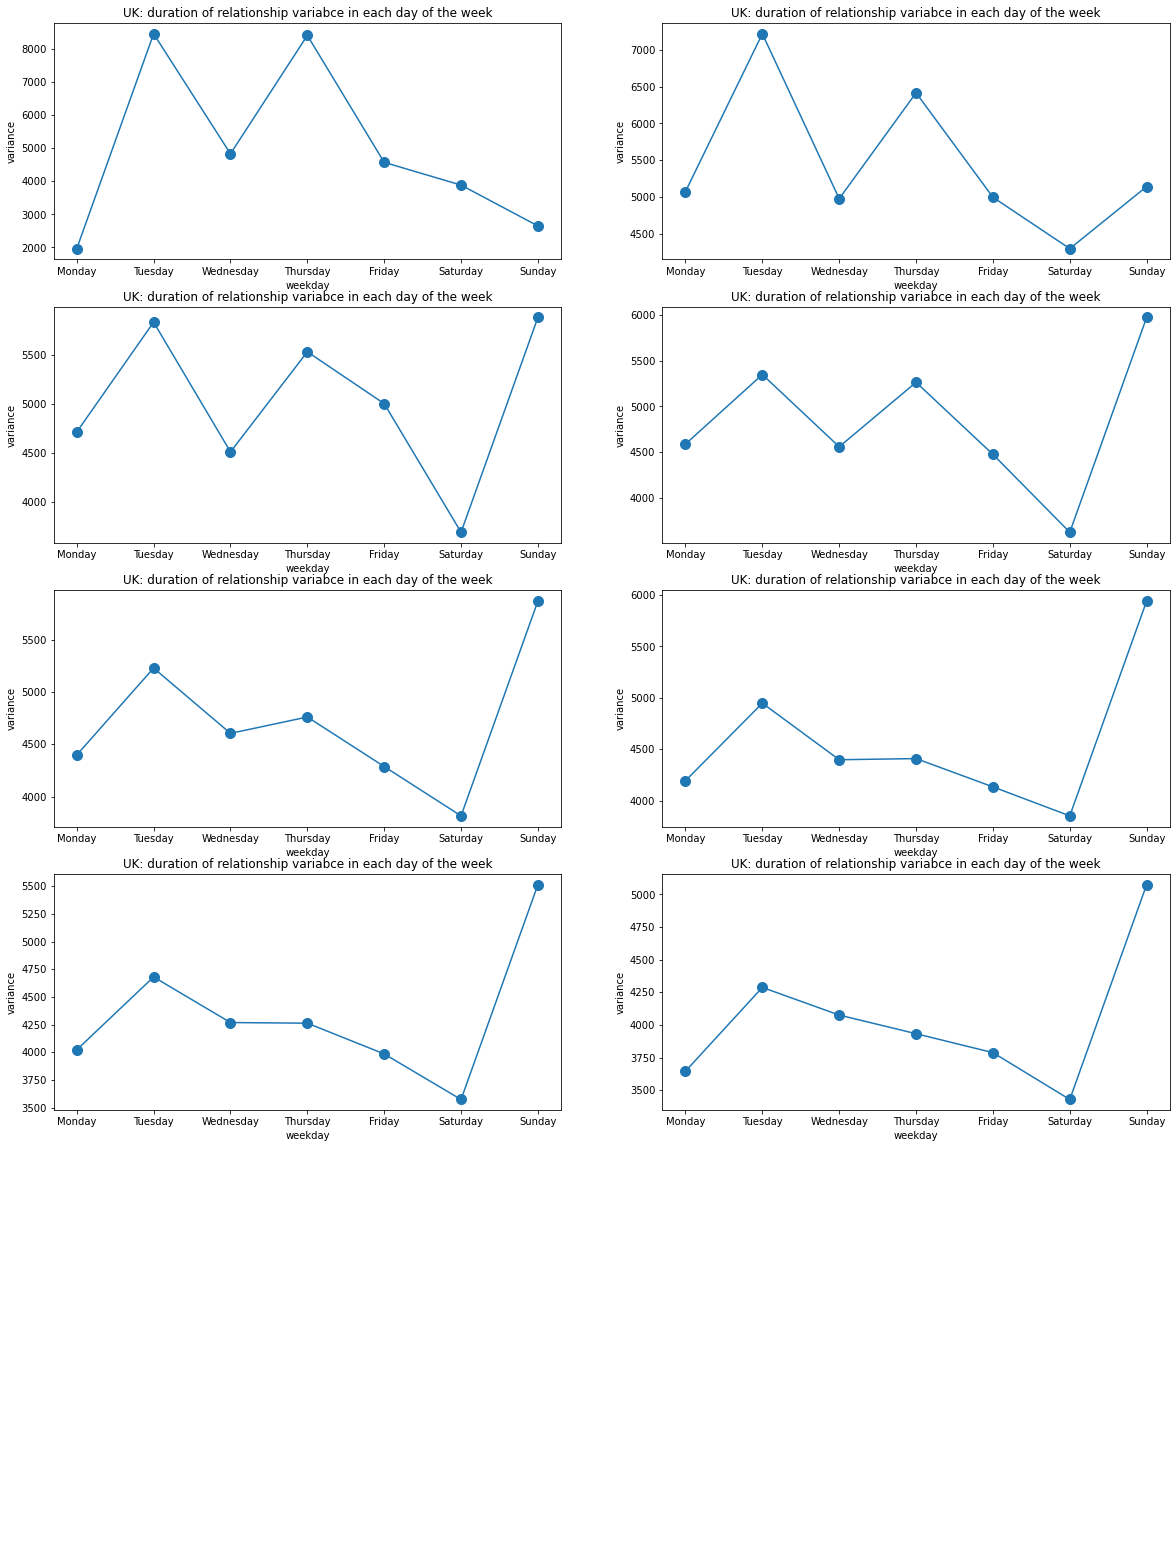

In [7]:
nc = 2
nr = 4
plt.figure(figsize=(10*nc, 5*nr))
p = 1
for nw in weekly.keys():
    plt.subplot(nr, nc, p)
    size = weekly[nw].groupby('weekday',sort = False)
    var = size.var()
    #  average duration of friendships in each day of the week
    plt.plot(var['ell'], linestyle='-', marker='o', markersize=10)
    plt.title('UK: duration of relationship variabce in each day of the week')
    plt.xlabel(var.index.name)
    plt.ylabel('variance')
    plt.annotate(f'{nw} weeks', (0.1, 50), fontsize=15)
    #plt.tight_layout()
    p += 1
# plt.savefig("/home/vsvh/Desktop/UKc.pdf", dpi=300)

# IT

In [8]:
daynames = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekly = {}
for nw in [7 * weeks for weeks in [1,4,8,12,16,20,24,28]]:
    subpairs = teeth['it'].loc[(teeth['it']['to'] >= 200) & (teeth['it']['to'] < 200 + nw)]
    subdata = data['it'][data['it']['pair'].isin(subpairs['pair'])].copy()
    subsubdata = pd.DataFrame()
    for t in subpairs['to'].unique():
        alters = list(subpairs.loc[subpairs['to'] == t]['pair'])
        tmp = subdata[subdata['pair'].isin(alters)]
        tmp = tmp.loc[tmp['t'] <= t + 200]
        subsubdata = subsubdata.append(tmp)
    tt = get_teeth(subsubdata)
    tt['weekday'] = tt['to'].map(lambda x: weekdays['it'][x])
    weekly[nw // 7] = pd.DataFrame()
    for i in range(7):
        tmp = tt.loc[tt['weekday'] == daynames[i]]
        tmp = tmp.sort_values(by=['ell']).reset_index(drop=True)
        tmp['xrel'] = tmp.index.map(lambda x: (x / len(tmp)) + i*2)
        weekly[nw // 7] = weekly[nw // 7].append(tmp).reset_index(drop=True)

In [12]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i])

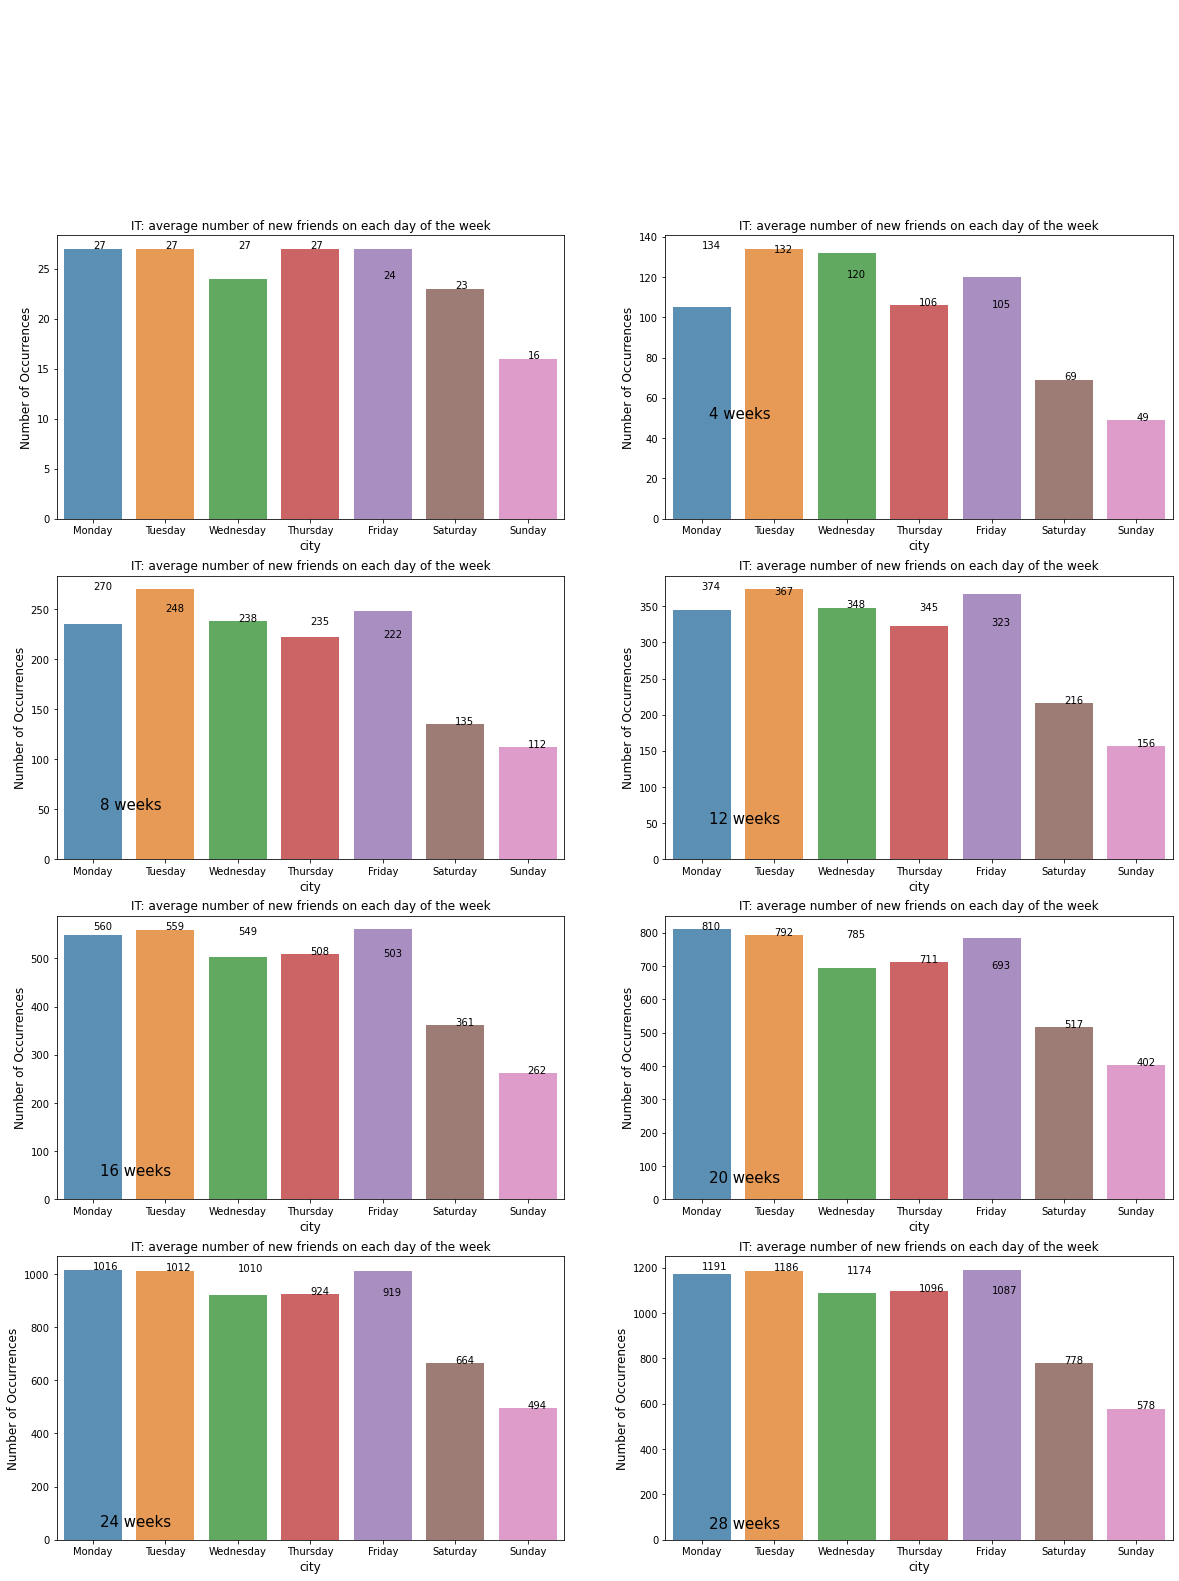

In [13]:
nc = 2
nr = 4
plt.figure(figsize=(10*nc, 6*nr))
p = 1  

for nw in weekly.keys():
    plt.subplot(nr, nc, p)
    value_counts  = weekly[nw]['weekday'].value_counts()
    sns.barplot(value_counts.index, value_counts.values, alpha=0.8, order=daynames)
    addlabels(value_counts.index, value_counts.values)
    plt.title('IT: average number of new friends on each day of the week')
    plt.ylabel('Number of Occurrences', fontsize=12)
    plt.xlabel('city', fontsize=12)
    plt.annotate(f'{nw} weeks', (0.1, 50), fontsize=15)
    #plt.tight_layout()
    p += 1
# plt.savefig("/home/vsvh/Desktop/UKc.pdf", dpi=300)

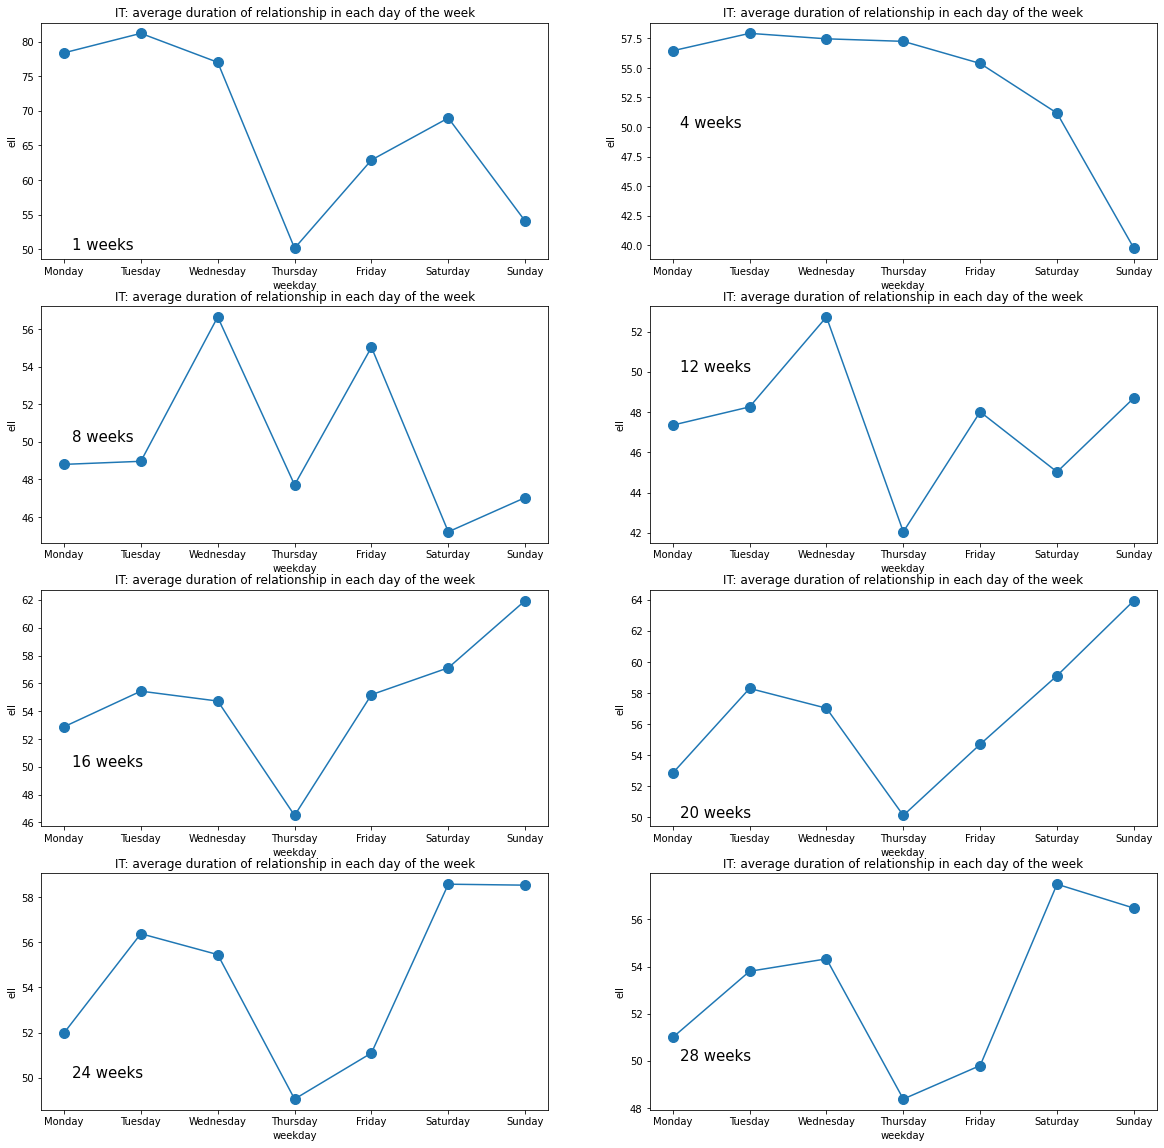

In [77]:
nc = 2
nr = 4
plt.figure(figsize=(10*nc, 5*nr))
p = 1
for nw in weekly.keys():
    plt.subplot(nr, nc, p)
    size = weekly[nw].groupby('weekday',sort = False)
    means = size.mean()
    #  average duration of friendships in each day of the week
    plt.plot(means['ell'], linestyle='-', marker='o', markersize=10)
    plt.title('IT: average duration of relationship in each day of the week')
    plt.xlabel(means.index.name)
    plt.ylabel('ell')
    plt.annotate(f'{nw} weeks', (0.1, 50), fontsize=15)
    #plt.tight_layout()
    p += 1
# plt.savefig("/home/vsvh/Desktop/UKc.pdf", dpi=300)

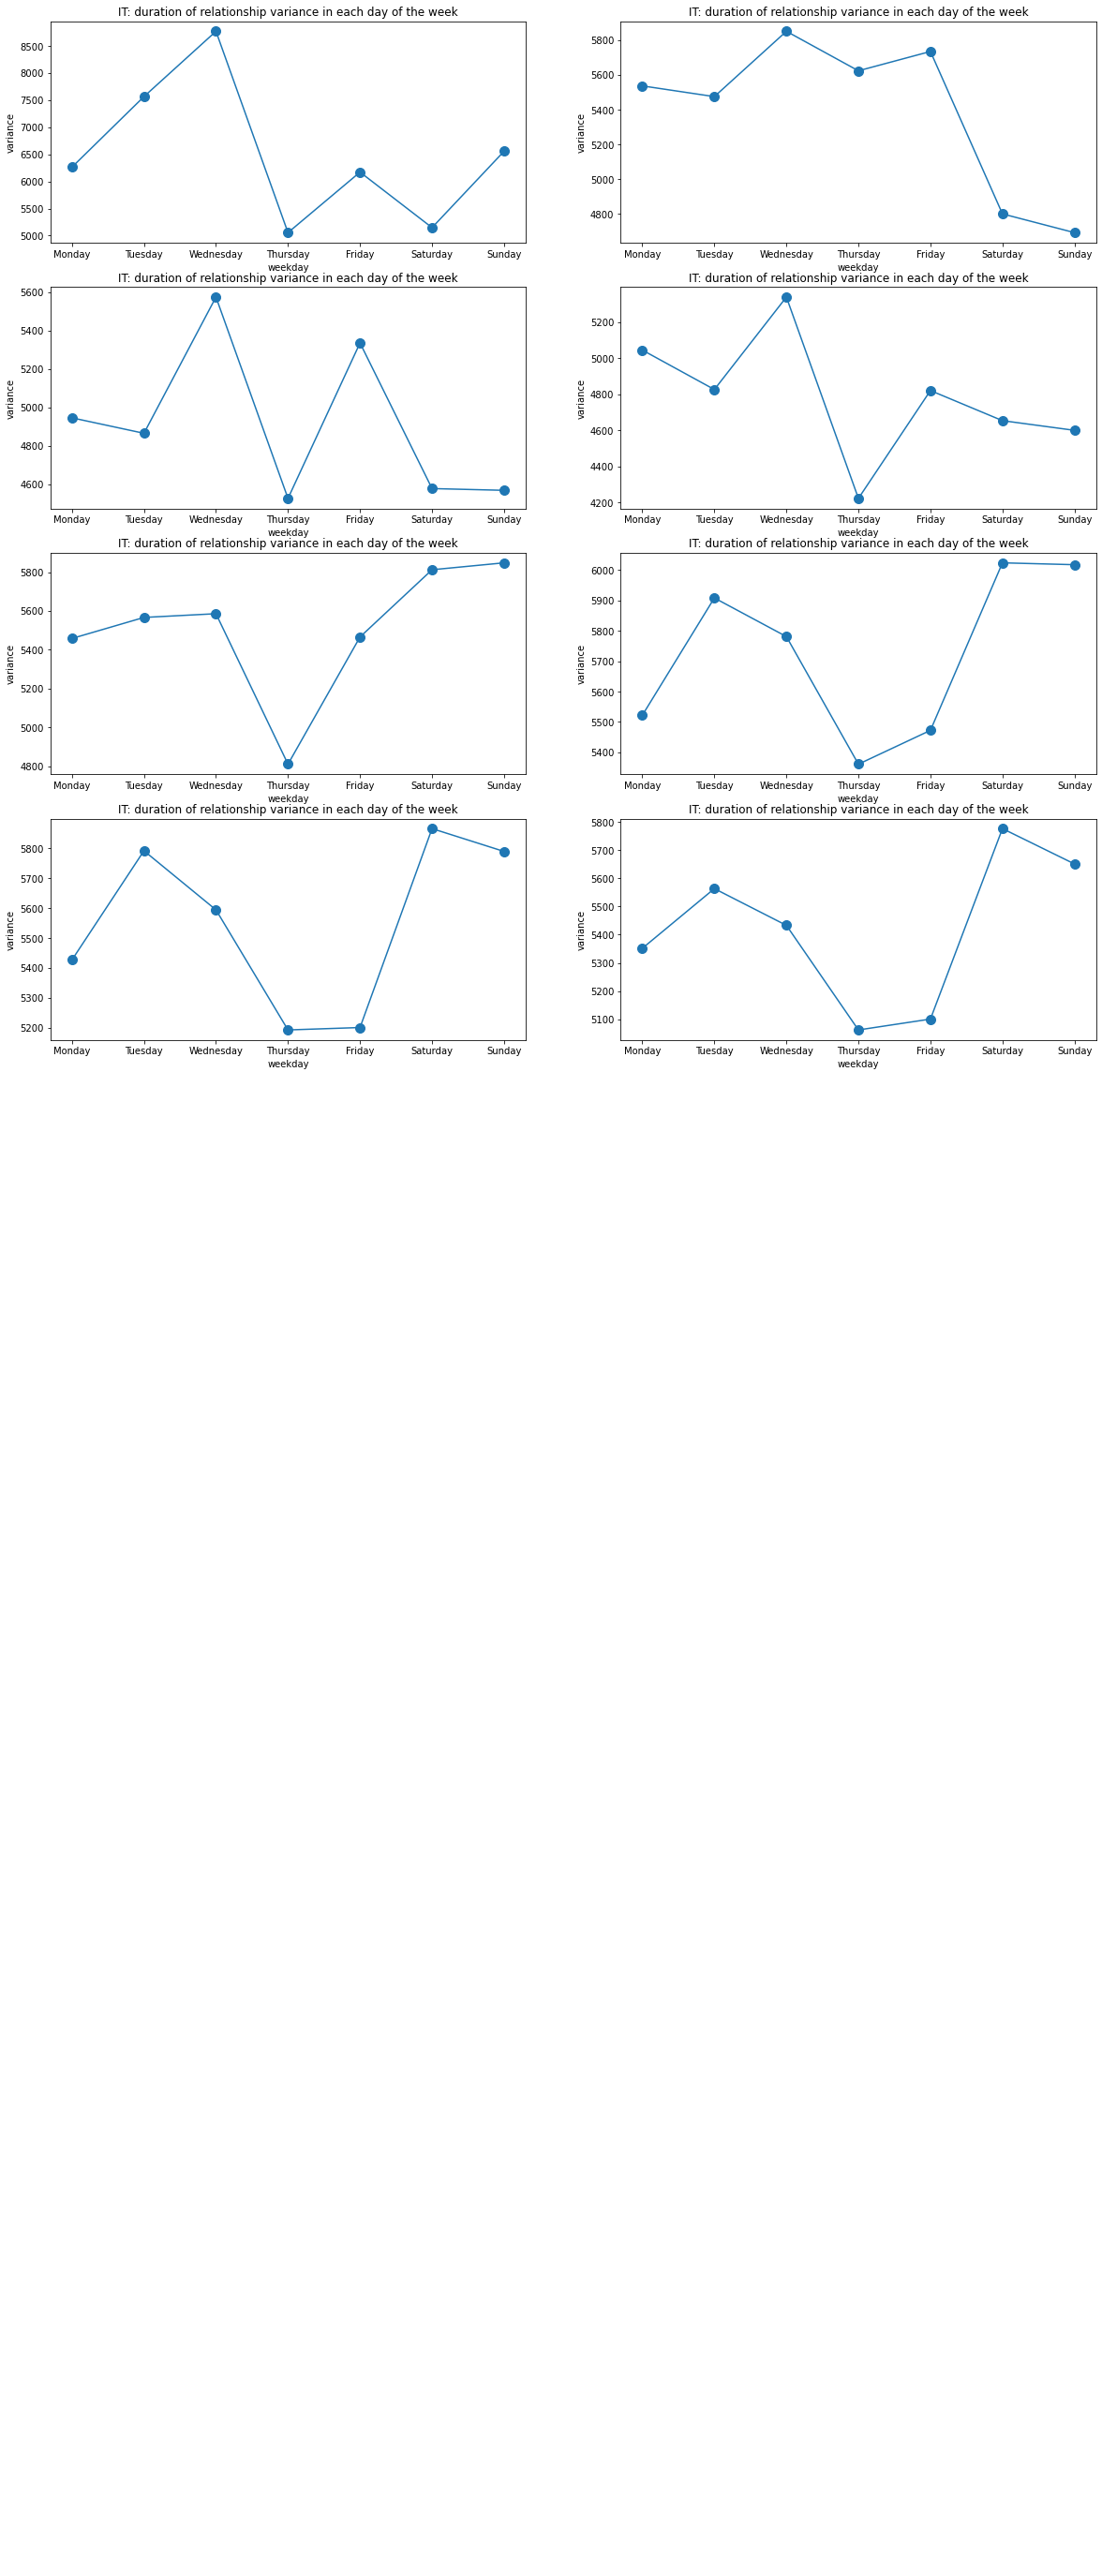

In [9]:
nc = 2
nr = 4
plt.figure(figsize=(10*nc, 5*nr))
p = 1
for nw in weekly.keys():
    plt.subplot(nr, nc, p)
    var = weekly[nw].groupby('weekday',sort = False).var()
    #  average duration of friendships in each day of the week
    plt.plot(var['ell'], linestyle='-', marker='o', markersize=10)
    plt.title('IT: duration of relationship variance in each day of the week')
    plt.xlabel(var.index.name)
    plt.ylabel('variance')
    plt.annotate(f'{nw} weeks', (0.1, 50), fontsize=15)
    #plt.tight_layout()
    p += 1